# Biophysical and reduced neuronal models

## Generic code architecture for model construction

In [2]:
#Modl params

#Run controls

#DAQ vector instantiation

#Initialization

#Helper fxns (eqns)

#Integrator

#Package DAQ vector(s) into intuitive data structure

#I.O

## Hodgkin-Huxley Neuron Model

### Charge conservation equation

$$C_{m}\frac{dV_{m}}{dt} = -\sum_{i \in \{I_{Na}, I_{K}, I_{pas}\}} I_{i} + I_{0}$$

### Current equations (where i $\in$ {Na, K, pas} and j, k, z $\geq$ 0)

$$I_{i} = \bar{g}_{i}m^{j}h^{k}n^{z}(V - E_{i})$$

### Gating dynamic equations (where p $\in$ {m, h, b})

$$\frac{dp}{dt} = \alpha_{p}(V_m)(1 - p) - \beta_{p}(V_{m})p$$

### Rate constant equations

#### m

$$\alpha_{m} = \frac{0.01(25 - V_{m})}{e^{\frac{25 - V_{m}}{10}} - 1}$$

$$\beta_{m} = 4e^{-\frac{V_{m}}{18}}$$

#### h

$$\alpha_{h} = 0.07e^{-\frac{V_{m}}{20}}$$

$$\beta_{h} = \frac{1}{e^{\frac{30 - V_{m}}{10}} - 1}$$

#### n

$$\alpha_{n} = \frac{0.01(10 - V_{m})}{e^{\frac{10 - V_{m}}{10}} - 1}$$

$$\beta_{n} = 0.125e^{-\frac{V_{m}}{80}}$$

#### $\infty$ (steady-state) equations (where p $\in$ {m, h, n})

$$p_{\infty} = \frac{\alpha_{p}}{\alpha_{p} + \beta_{p}} $$


In [3]:
###Sys block
from warnings import simplefilter
simplefilter(action = 'ignore')
from random import seed
seed(120622)

###Lib block
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sbn
from random import gauss

In [4]:
###Main block
#Modl params
gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
e_na, e_k, e_pas = 115, -12, 10.6
i_0, c_m = 10, 1

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ vector instantiation
v, m, h, n = [], [], [], []

#Helper fxns (eqns)
def alpha_m(v):
    return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))

def beta_m(v):
    return(4 * np.exp(-v / 18))

def alpha_h(v):
    return(0.07 * np.exp(-v / 20))

def beta_h(v):
    return(1 / (np.exp ((30 - v) / 10) + 1))

def alpha_n(v):
    return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))

def beta_n(v):
    return(0.125 * np.exp(-v / 80))

def dmdt(v, m):
    return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))

def dhdt(v, h):
    return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))

def dndt(v, n):
    return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))

def i_na(gbar_na, m, h, v, e_na):
    return((gbar_na * (m ** 3) * h * (v - e_na)))

def i_k(gbar_k, n, v, e_k):
    return((gbar_k * (n ** 4)) * (v - e_k))

def i_pas(gbar_pas, v, e_pas):
    return(gbar_pas * (v - e_pas))
    
def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, i_0, c_m):
    return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + i_0) / c_m)

###Initialization
##Initialize voltage
v.append(0)

##Initialize state vars
#Fxns iterable
fxns = [[alpha_m, beta_m],
        [alpha_h, beta_h],
        [alpha_n, beta_n]]

#State-vars iterable
sVars = [m, h, n]

#Iteratively initialize state vars
for i,_ in enumerate(fxns):
    sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                              gbar_na, gbar_k, gbar_pas, 
                              e_na, e_k, e_pas,
                              i_0, c_m))
    m.append(m[i] + dt * dmdt(v[i], m[i]))
    h.append(h[i] + dt * dhdt(v[i], h[i]))
    n.append(n[i] + dt * dndt(v[i], n[i]))

#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': v}) \
         .query('t >= 960 & t <= 995') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,960.000,-3.220631
1,960.025,-3.167730
2,960.050,-3.114805
3,960.075,-3.061856
4,960.100,-3.008888


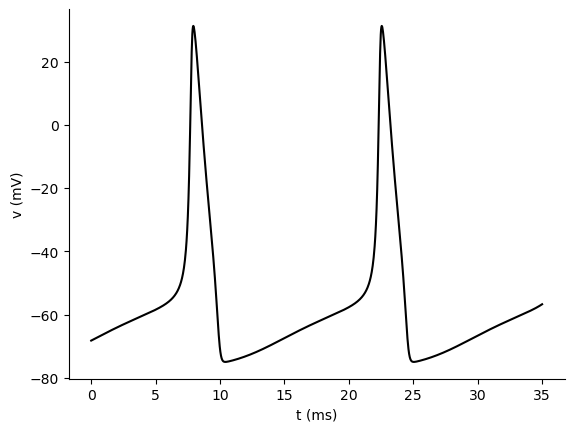

In [5]:
#Visualization
plt.figure()
plt.plot(data['t'] - min(data['t']), 
         data['v'] - 65,
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Hodgkin-Huxley Model Compared to Biological Spiker

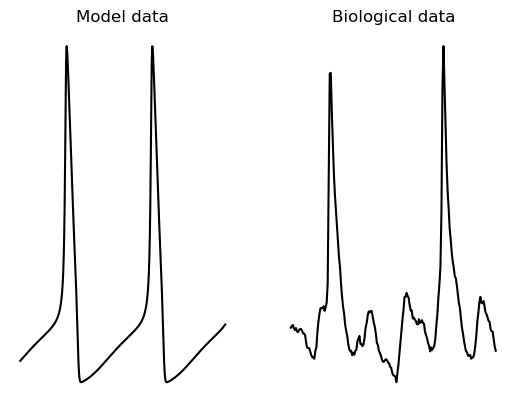

In [6]:
#Data dump
biolData = pd.read_csv('./data/biologicalSpiker.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hodgkin-Huxley Model With Noise Compared to Biological Spiker

### Charge conservation equation with additive noise

$$C_{m}\frac{dV_{m}}{dt} = -\sum_{i \in \{I_{Na}, I_{K}, I_{pas}\}} I_{i} + w\xi + I_{0}$$


In [7]:
###Main block
#Modl params
gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
e_na, e_k, e_pas = 115, -12, 10.6
w, i_0, c_m = 25, 10, 1

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ vector instantiation
v, m, h, n = [], [], [], []

#Helper fxns (eqns)
def alpha_m(v):
    return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))

def beta_m(v):
    return(4 * np.exp(-v / 18))

def alpha_h(v):
    return(0.07 * np.exp(-v / 20))

def beta_h(v):
    return(1 / (np.exp ((30 - v) / 10) + 1))

def alpha_n(v):
    return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))

def beta_n(v):
    return(0.125 * np.exp(-v / 80))

def dmdt(v, m):
    return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))

def dhdt(v, h):
    return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))

def dndt(v, n):
    return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))

def i_na(gbar_na, m, h, v, e_na):
    return((gbar_na * (m ** 3) * h * (v - e_na)))

def i_k(gbar_k, n, v, e_k):
    return((gbar_k * (n ** 4)) * (v - e_k))

def i_pas(gbar_pas, v, e_pas):
    return(gbar_pas * (v - e_pas))
    
def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, w, i_0, c_m):
    return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + (w * gauss(mu = 0, sigma = 1)) + i_0) / c_m)

###Initialization
##Initialize voltage
v.append(0)

##Initialize state vars
#Fxns iterable
fxns = [[alpha_m, beta_m],
        [alpha_h, beta_h],
        [alpha_n, beta_n]]

#State-vars iterable
sVars = [m, h, n]

#Iteratively initialize state vars
for i,_ in enumerate(fxns):
    sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                              gbar_na, gbar_k, gbar_pas, 
                              e_na, e_k, e_pas,
                              w, i_0, c_m))
    m.append(m[i] + dt * dmdt(v[i], m[i]))
    h.append(h[i] + dt * dhdt(v[i], h[i]))
    n.append(n[i] + dt * dndt(v[i], n[i]))

#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': v}) \
         .query('t >= 960 & t <= 995') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,960.000,-8.686479
1,960.025,-7.601745
2,960.050,-7.555722
3,960.075,-7.411587
4,960.100,-8.228261


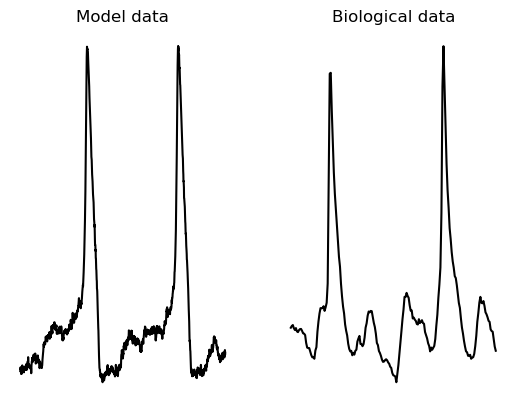

In [8]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hindmarsh-Rose Neuron Model

### System of differential equations

$$\frac{dx}{dt} = y - ax^{3} + bx^{2} - z + i$$

$$\frac{dy}{dt} = c - dx^{2} - y$$

$$\frac{dz}{dt} = r(s(x - x_{1}) - z)$$

In [9]:
###Main block
#Modl params
a, b, c, d = 1, 3, 1, 5
r, s, x0, i_ = 0.001, 4, -1.6, 2

#Run controls
time, dt = 2000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 3))

#Initialization
sVars[0] = np.array([0.5, 0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    x, y, z = sVars

    #Compute RHS of ODEs
    dxdt = y - a * (x ** 3) + b * (x ** 2) - z + i_
    dydt = c - d * (x ** 2) - y
    dzdt = r * (s * (x - x0) - z)

    #Fxn I.O
    return(np.array([dxdt, dydt, dzdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'x': sVars[:, 0]}) \
         .query('t >= 1000 & t <= 1750') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,x
0,1000.00,-1.532801
1,1000.01,-1.532784
2,1000.02,-1.532768
3,1000.03,-1.532751
4,1000.04,-1.532735


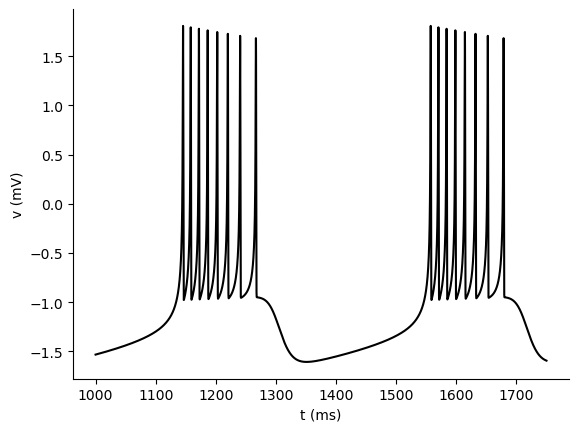

In [13]:
#Visualization
plt.figure()
plt.plot(data['t'], 
         data['x'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Hindmarsh-Rose Model Compared to Biological Burster

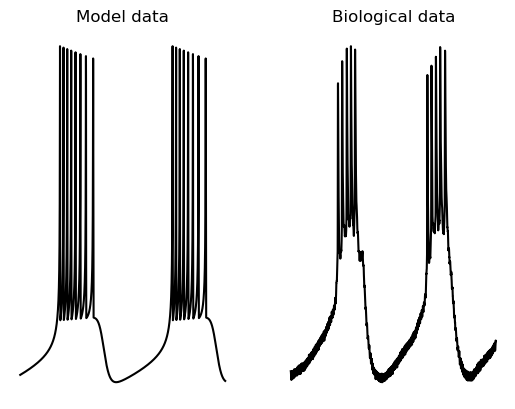

In [14]:
#Data dump
biolData = pd.read_csv('./data/biologicalBurster.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['x'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hindmarsh-Rose Model With Noise Compared to Biological Burster

### Voltage-representing, state-variable equation with additive noise

$$\frac{dx}{dt} = y - ax^{3} + bx^{2} - z + w\xi + i$$

In [15]:
###Main block
#Modl params
a, b, c, d = 1, 3, 1, 5
r, s, x0, i_ = 0.001, 4, -1.6, 2
w = 1

#Run controls
time, dt = 2000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 3))

#Initialization
sVars[0] = np.array([0.5, 0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    x, y, z = sVars

    #Compute RHS of ODEs
    dxdt = y - a * x ** 3 + b * x ** 2 - z + (w * gauss(mu = 0, sigma = 1)) + i_
    dydt = c - d * x ** 2 - y
    dzdt = r * (s * (x - x0) - z)

    #Fxn I.O
    return(np.array([dxdt, dydt, dzdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'x': sVars[:, 0]}) \
         .query('t >= 1000 & t <= 1750') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,x
0,1000.00,-1.472408
1,1000.01,-1.482756
2,1000.02,-1.483776
3,1000.03,-1.480185
4,1000.04,-1.478846


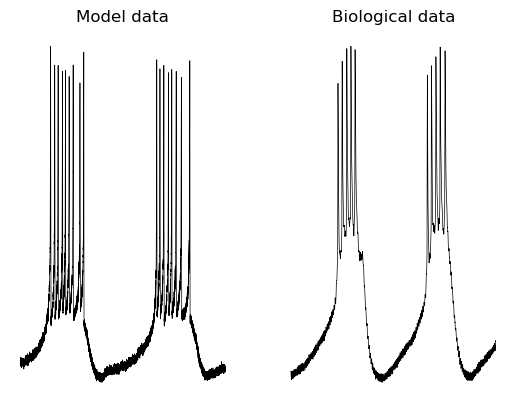

In [16]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['x'],
         linewidth = 0.5,
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         linewidth = 0.5,
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Draw visualization to jupyter
plt.show()

## Izhikevich Neuron Model

### System of differential equations

$$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u + i$$

$$\frac{du}{dt} = a(bv - u)$$

<p style = "text-align: center;">if $v = 30 mV$ then</p> 

$$v \leftarrow c$$
$$u \leftarrow u + d$$

## ...as spiker

In [17]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -65, 8
i_ = 10

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i, T in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,v
0,900.00,-70.935316
1,900.01,-70.932249
2,900.02,-70.929181
3,900.03,-70.926114
4,900.04,-70.923046


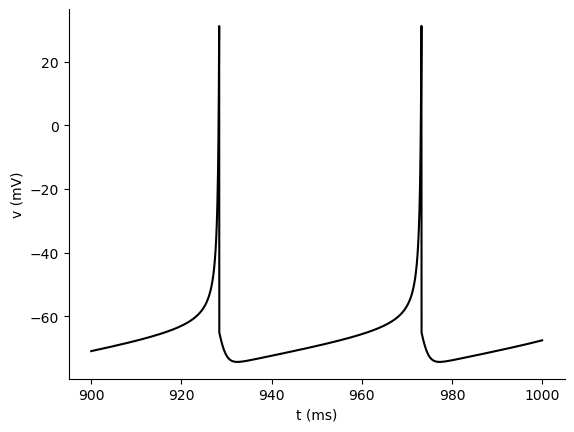

In [18]:
#Visualization
plt.figure()
plt.plot(data['t'], 
         data['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## ...as burster

In [19]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -50, 2
i_ = 15

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i, T in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data_ = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
          .query('t >= 900') \
          .reset_index(drop = True) 

#I.O
data_.head()

,t,v
0,900.00,-69.019385
1,900.01,-69.014446
2,900.02,-69.009506
3,900.03,-69.004563
4,900.04,-68.999619


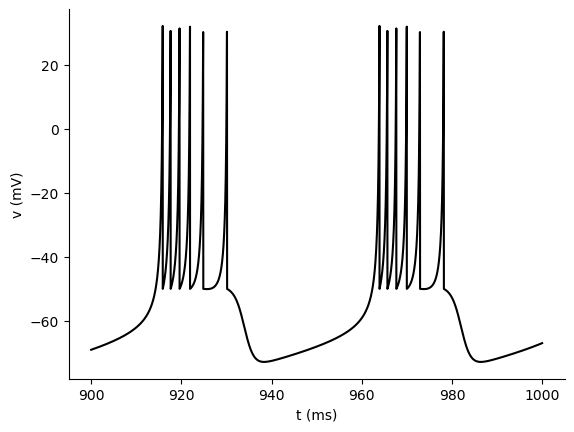

In [20]:
#Visualization
plt.figure()
plt.plot(data_['t'], 
         data_['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Izhikevich Model Compared to Biological Neurons

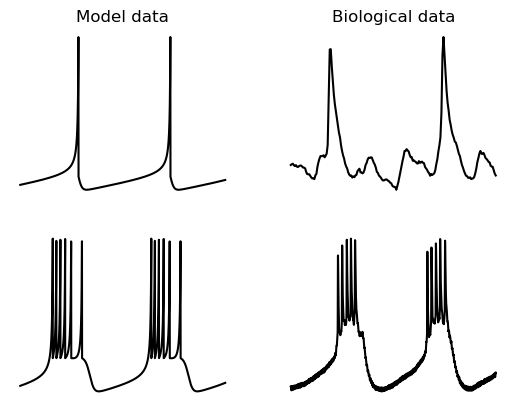

In [21]:
#Data dump
biolData = pd.read_csv('./data/biologicalSpiker.csv')
biolData_ = pd.read_csv('./data/biologicalBurster.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of iterables
sp = [221, 222, 223, 224]
xy = [data, biolData, data_, biolData_]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(xy[i]['t'],
             xy[i]['v'],
             color = 'black')
    plt.axis('off')

    if i == 0:
        plt.title('Model data')

    if i == 1:
        plt.title('Biological data')

#Render visualization to jupyter
plt.show()

## Izhikevich Model With Noise Compared to Biological Neurons

### Voltage-representing, state-variable equation with additive noise

$$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u + w\xi + i$$

## ...as spiker

In [22]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -65, 8
w, i_ = 10, 10

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i, T in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,v
0,900.00,-69.244225
1,900.01,-69.222449
2,900.02,-69.261061
3,900.03,-69.312373
4,900.04,-69.442575


## ...as burster

In [23]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -50, 2
w, i_ = 10, 15

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i, T in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data_ = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
          .query('t >= 900') \
          .reset_index(drop = True) 

#I.O
data_.head()

,t,v
0,900.00,-62.993644
1,900.01,-62.786875
2,900.02,-62.499059
3,900.03,-62.436780
4,900.04,-62.565752


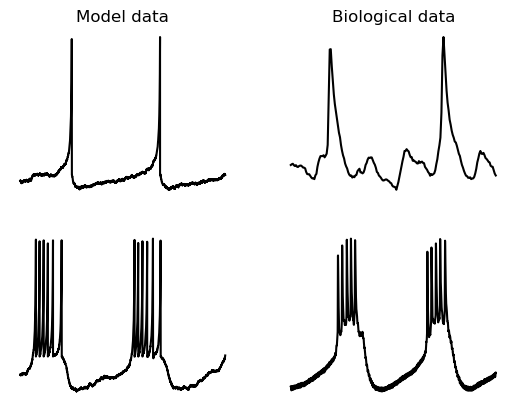

In [24]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of iterables
sp = [221, 222, 223, 224]
xy = [data, biolData, data_, biolData_]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(xy[i]['t'],
             xy[i]['v'],
             color = 'black')
    plt.axis('off')

    if i == 0:
        plt.title('Model data')

    if i == 1:
        plt.title('Biological data')

#Render visualization to jupyter
plt.show()